![Codenation](https://forum.codenation.com.br/uploads/default/original/2X/2/2d2d2a9469f0171e7df2c4ee97f70c555e431e76.png)

__Autor__: Kazuki Yokoyama (kazuki.yokoyama@ufrgs.br)

# Validação de modelos

![cover](https://scikit-learn.org/stable/_images/grid_search_workflow.png)

Neste módulo, falaremos sobre validação de modelos de predição. As ideias apresentadas aqui aplicam-se _mutati mutandis_ tanto para regressão, quanto para classificação. Veremos porque utilizar os mesmos dados de treinamento para avaliar o desempenho do modelo é um erro e como podemos fazer certo com dados de validação e _cross-validation_.

## Importação das bibliotecas

In [0]:
import functools
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as sct
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.datasets import load_digits, make_blobs, make_classification
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
# Algumas configurações para o matplotlib.
%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 12)

In [0]:
np.random.seed(1000)

## Validação em treinamento e teste

Sabemos que além de treinar um modelo, precisamos também avaliar o seu desempenho em novos dados, não vistos durante o treinamento. Geralmente, medimos o desempenho de um modelo através de uma função do erro: quanto menor, melhor. E utilizamos essa função para escolher o melhor modelo, ou a melhor combinação de hiperparâmetros de um modelo.

Acontece que o desempenho de um modelo quando avaliado sobre os dados de treinamento é bem diferente quando avaliado sobre dados nunca antes vistos. Considere os gráficos abaixo (retirados de Tibshirani et al.):

![terminology](https://drive.google.com/uc?export=download&id=1Pjiyc1WbXH9Q9GJFkZdOOw2u8_abR6Kq)

O gráfico à esquerda mostra dados gerados a partir da curva em preto e três modelos de regressão treinados para esses dados. Repare como há um crescente nível de ajuste fino dos modelos aos dados de treinamento, do mais rígido (laranja) ao mais ajustado (verde). Chamamos esse nível de adequação do modelo aos dados de flexibilidade: quanto mais flexível, mais liberdade o modelo tem para se ajustar aos dados. 

Podemos alterar a flexibilidade mudando de modelo (certos modelos são naturalmente mais flexíveis que outros), ou alterando os hiperparâmetros de um mesmo tipo de modelo como, por exemplo, ao criarmos mais variáveis explicativas (e.g., polinomiais) para um modelo de regressão linear.

O gráfico mostra os dois tipos. Em laranja, temos um modelo de regressão linear. Em azul, um modelo de _spline_ (uma forma de interpolação numérica capaz de se ajustar a dados altamente não lineares). E em verde, um _spline_ ainda mais flexível, através de alterações nos parâmetros do modelo.

O mais interessante porém encontra-se no gráfico à direita. Nele, são mostradas as curvas de erro (medido pelo MSE) dos modelos em relação aos dados de treinamento (em cinza), aos dados de teste (em vermelho) e o mínimo erro teórico (linha tracejada), em função da flexibilidade do modelo. Os pontos representam o desempenho de cada um dos modelos nesses conjuntos.

Note como o erro de treinamento é dado por uma curva decrescente: quanto mais flexível é o modelo, menor é o seu erro no conjunto de treinamento. Baseado somente nessa curva, poderíamos supor erradamente que modelos mais flexíveis são sempre melhores. No caso extremo, poderíamos criar um modelo tão flexível quanto conseguíssemos (por exemplo, adicionando centenas ou milhares de variáveis novas) até que alcançássemos um erro próximo de zero. Infelizmente, esse não é o caso (ou felizmente, senão seria muito sem graça).

Se fizermos isso, estaremos criando modelos que fazem __overfitting__ dos dados: o modelo "decora" os dados de treinamento e tenta se ajustar o melhor possível a eles, perdendo capacidade de generalização. Ao perder generalização, o modelo torna-se incapaz de realizar predições adequadas para dados nunca antes vistos.

![overfitting](https://drive.google.com/uc?export=download&id=1FFk46KAdZpq6kwcKiysXspsO0fhQPd_u)

Como o erro de treinamento não é uma medida muito confiável do desempenho dos modelos, precisamos de outra forma de avaliá-los. Essa outra forma é através do erro de teste. O erro de teste é um medida de desempenho do modelo em dados não utilizados durante o treinamento, ou seja, totalmente novos para o modelo.

Poderíamos pensar que o erro de teste segue o mesmo padrão do erro de treinamento, ou seja, que ele aumenta com a flexibilidade do modelo. Mas esse não é o caso.

Na verdade, o erro de teste tem a forma clássica de 'U': ele começa alto para modelos pouco flexíveis, diminui com o aumento da flexibilidade até certo ponto (lembre deste "certo ponto"), e depois volta a crescer indefinidamente com modelos demasiadamente flexíveis.

Antes de entedermos o compartamento do gráfico à direita, vale lembrar que o erro total cometido pelo modelo (aqui o MSE) é a soma do erro derivado da variância, do viés e do erro irredutível. E que quanto mais flexível é um modelo, menor é seu viés, mas maior é sua variância. Daí o _tradeoff_ viés-variância.

Agora, observe a curva vermelha no gráfico à direita. O modelo laranja (regressão linear) possui baixa flexibilidade, mas alto viés. Isso o leva a cometer outro tipo de erro: __underfitting__. Com _underfitting_, o modelo é demasiadamente simples para explicar a realidade dos dados, também levando à predições fracas.

O modelo em azul (um _spline_) possui um viés menor, mas uma variância naturalmente maior que uma regressão linear simples. Porém, a diminuição no viés superou o crescimento da variância, de forma que a soma dos dois resultou em um erro total menor.

Se continuarmos aumentando a flexibilidade do _spline_, como fazemos com o modelo em verde, chegaremos no caso onde a diminuição do viés não compensou o crescimento rápido da variância do modelo, resultando em um novo crescimento do erro total.

Analisando somente o erro de treinamento, seríamos levados a crer que o modelo verde é o melhor. Porém, de conhecimento do erro de teste, vemos que ele na verdade apresenta um erro real quase tão alto quanto a regressão linear simples. E que o melhor modelo é de fato o _spline_ intermediário em azul.

Agora que sabemos que o verdadeiro desempenho de um modelo é dado pelo seu erro em dados nunca antes vistos, como obtemos esse valor na prática?

Essa não é uma tarefa tão trivial. Veremos agora algumas abordagens para esse problema, começando pelo conjunto de teste.

## Conjuntos de validação e teste

As curvas no gráfico à direita foram obtidas avaliando-se o desempenho em dados nunca antes vistos. Isso só foi possível porque era um experimento onde se conhecia o verdadeiro processo de geração de dados (a curva preta no gráfico à esquerda), sendo então possível se criar mais dados exclusivamente para o teste. Na vida real, não dispomos de tal luxo.

O que possuímos é um conjunto de dados limitado, da onde devemos treinar o modelo, avaliar seu desempenho, tunar hiperparâmetros etc. Como fazemos tanto com tão pouco?

Uma primeira abordagem é separar o conjunto de dados em dois grupos, reservando uma parte para treinamento do modelo e outra para o seu teste. Essa abordagem é chamada de "conjunto de validação e teste (ou _hold-out_)".

![validation-test](https://drive.google.com/uc?export=download&id=17hsdHMYXcJEeugN4DT5Wriz63McvaqrF)

Nessa abordagem, dividimos o conjunto original de dados em três partes: treinamento, validação e teste (_hold-out_). É altamente indicado randomizar o conjunto de dados antes de fazer o particionamento. Isso pode evitar a introdução de um viés devido a ordenação do conjunto de dados original.

O conjunto de treinamento é autoexplicativo. Ele será utilizado para treinar o nosso modelo. Essa é onde fica a maior parte dos dados, com cerca de 50% ~ 70% dos dados. Já foi mostrado como o erro do modelo medido nesses dados pode ser enganoso.

Para ajustarmos os hiperparâmetros do modelo, utilizamos o conjunto de validação. Cada combinação de hiperparâmetros é treinada sobre os dados de treinamento e avaliada sobre os dados de validação. Como esses dados não participaram do treinamento do modelo, o erro é uma boa medida do real desempenho do modelo sobre dados nunca vistos.

Por fim, quando tivermos escolhido o modelo e a melhor combinação de hiperparâmetros, utilizamos o conjunto de teste para a avaliação final do desempenho do modelo. Esse é o desempenho que será reportado. Assim como o de validação, o erro de teste é naturalmente maior do que o erro de treinamento, mas também mais real.

Apesar de ser simples o suficiente para ser implementada sem dificuldades, essa abordagem possui alguns problemas. O primeiro é a redução da quantidade de dados disponíveis para realizar o treinamento do modelo. Alguns modelos não alcançam bom resultado se não forem treinados com bastante dados. Diminuir a quantidade de dados de treinamento nesse caso é de nenhuma ajuda. Como resultado, temos que o erro reportado pela validação superestima o verdadeiro erro de teste, que seria obtido se o modelo fosse treinado com todos dados disponíveis.

O segundo problema é que o resultado do modelo pode ser susceptível à escolha dos dados de treinamento/validação/teste. Isso significa que diferentes particionamentos do conjunto de dados original pode levar a modelos com desempenhos bem diferentes.

Apesar desses problemas, essa abordagem inicial nos deixa uma lição que levaremos daqui em diante: sempre separe uma parte do conjunto de dados original para a realização da performance final do modelo, o conjunto de teste (ou _hold-out_).

In [0]:
digits_dataset = load_digits()

images = digits_dataset.images
target = digits_dataset.target

images.shape, target.shape

((1797, 8, 8), (1797,))

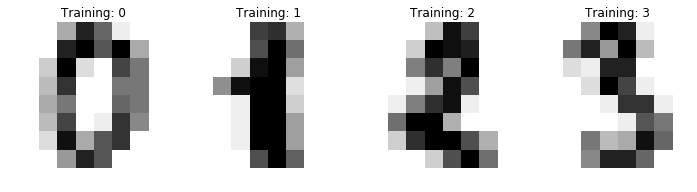

In [0]:
images_and_labels = list(zip(images, target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [0]:
digits = images.reshape((len(images), -1))

digits.shape

(1797, 64)

In [0]:
X_train_val, X_test, y_train_val, y_test = train_test_split(digits, target, test_size=0.25)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=1/3)

X_train.shape, X_val.shape, X_test.shape

((898, 64), (449, 64), (450, 64))

In [0]:
criterions = ["gini", "entropy"]
max_depths = [2**i for i in range(5)]
min_samples_leaves = [2**i for i in range(5)]

param_candidates = [(criterion, max_depth, min_samples_leaf)
                    for criterion in criterions
                    for max_depth in max_depths
                    for min_samples_leaf in min_samples_leaves]

random_candidates_idx = sorted(np.random.choice(range(len(param_candidates)), size=5, replace=False))

random_candidates = []
for random_idx in random_candidates_idx:
    random_candidates.append(param_candidates[random_idx])
    
    print(f"{random_idx}: {param_candidates[random_idx]}")

8: ('gini', 2, 8)
22: ('gini', 16, 4)
25: ('entropy', 1, 1)
28: ('entropy', 1, 8)
46: ('entropy', 16, 2)


In [0]:
results = {}
for param_candidate in param_candidates:
    criterion = param_candidate[0]
    max_depth = param_candidate[1]
    min_samples_leaf = param_candidate[2]
    
    tree = DecisionTreeClassifier(criterion=criterion,
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf)
    
    tree.fit(X_train, y_train)
    
    y_val_pred = tree.predict(X_val)
    
    results[param_candidate] = accuracy_score(y_val, y_val_pred)


for random_candidate in random_candidates:
    print(f"{random_candidate} score: {results[random_candidate]}")

('gini', 2, 8) score: 0.3051224944320713
('gini', 16, 4) score: 0.8240534521158129
('entropy', 1, 1) score: 0.16926503340757237
('entropy', 1, 8) score: 0.16926503340757237
('entropy', 16, 2) score: 0.8663697104677061


In [0]:
best_params = max(results.keys(), key=lambda k: results[k])

best_params, results[best_params]

(('entropy', 16, 2), 0.8663697104677061)

In [0]:
best_tree = DecisionTreeClassifier(criterion=best_params[0],
                                   max_depth=best_params[1],
                                   min_samples_leaf=best_params[2])

y_test_pred = tree.fit(X_train, y_train).predict(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)

accuracy_test

0.7711111111111111

In [0]:
X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

y_test_pred = DecisionTreeClassifier(criterion=best_params[0],
                                   max_depth=best_params[1],
                                   min_samples_leaf=best_params[2]).fit(X_train_val, y_train_val).predict(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)

accuracy_test

0.8644444444444445

## _Cross-validation_

Vimos que uma deficiência da abordagem do conjunto de validação é diminuir a quantidade de dados do conjunto de treinamento. O método do _cross-validation_ nos permite realizar validação sem abrir mão dos dados de treinamento. _Cross-validation_ (ou validação cruzada) é uma técnica estatística iterativa para estimação do erro de teste, ou seja, sobre dados nunca antes vistos, sem que seja necessário separar um conjunto exclusivo para esse fim.

> De agora em diante, consideramos que uma parte do conjunto original de dados já foi separada para o conjunto de teste (ou _hold-out_). O que resta, iremos chamar de "conjunto de _cross-validation_".

Para realizar o o $k$-_fold cross-validation_, embaralhamos e dividimos o conjunto de _cross-validation_ em $k$ partes o mais iguais possível chamadas _folds_. Na primeira iteração do método, separamos a primeira _fold_ como conjunto de validação e utilizamos as $k-1$ _folds_ restantes para o treinamento do modelo. O modelo treinado é então avaliado na primeira _fold_ e tem seu desempenho registrado, $\text{MSE}_{1}$. Na segunda iteração, separamos a segunda _fold_ para teste e utilizamos as $k-1$ _folds_ para treinamento. O desempenho de teste do modelo na segunda _fold_ é registrado em $\text{MSE}_{2}$. Repetimos esse processo por todas $k$ _folds_, obtendo $k$ erros $\text{MSE}_{i} (i \in \{1, 2, \cdots, k\})$. No final, calculamos a média dos $k$ $\text{MSE}$ obtidos como o erro de validação do modelo. Esse erro de validação é utilizado para comparar modelos com diferentes combinações de hiperparâmetros. Em outras palavras, o erro de _cross-validation_ pode ser utilizado para tunar os hiperparâmetros do modelo.

As escolhas mais comuns para $k$ são 5 e 10, ou seja, dividimos o conjunto de _cross-validation_ em 5 ou 10 partes iguais para a validação. Esses valores demonstraram de forma empírica levar às melhores estimativas do erro de teste real.

Por fim, quando tivermos um modelo resolvido, avaliamos o seu desempenho com o conjunto de teste, intocado até este momento. Esse é o erro final do nosso modelo e é ele que devemos reportar.

Um esquemático do $k$-_fold cross-validation_ é mostrado abaixo:

![cross-validation](https://drive.google.com/uc?export=download&id=1WCSJJtXUsDIr1aUKJn1R_AV7JuLfLoB-)

Muitas implementações do _cross-validation_ adicionam uma etapa a mais a todo processo: eles retreinam o modelo escolhido com todos os dados disponíveis. Uma vez que os hiperparâmetros do modelo já foram escolhidos por _cross-validation_, podemos nos dar ao luxo de utilizar todos os dados disponíveis para treinar o modelo e assim melhorar sua qualidade.

Uma das desvantagens do $k$-_fold cross-validation_ é seu custo computacional. Quando maior o valor de $k$, mais iterações do método, e consequentemente, mais modelos deverão ser treinados. Por exemplo, com $k = 10$, teremos 10 iterações e 10 modelos inteiros sendo treinados. Dependendo do tipo e natureza do modelo, essa pode ser uma tarefa bastante demorada.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(digits, target, test_size=0.25)

X_train.shape, X_test.shape

((1347, 64), (450, 64))

In [0]:
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [2**i for i in range(5)],
              "min_samples_leaf": [2**i for i in range(5)]}

In [0]:
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

grid_search.cv_results_["mean_test_score"]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


array([0.1952487 , 0.1952487 , 0.1952487 , 0.1952487 , 0.1952487 ,
       0.31106162, 0.31106162, 0.31106162, 0.31106162, 0.31106162,
       0.62657758, 0.62435041, 0.62360802, 0.62286563, 0.62138085,
       0.81811433, 0.81365999, 0.80697847, 0.79213066, 0.77208612,
       0.83073497, 0.82182628, 0.81959911, 0.79584261, 0.77208612,
       0.18856719, 0.18856719, 0.18856719, 0.18856719, 0.18856719,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.71640683, 0.71640683, 0.71566444, 0.71269488, 0.70749814,
       0.8359317 , 0.84261321, 0.83073497, 0.80920564, 0.78544915,
       0.84929473, 0.84484039, 0.83518931, 0.80920564, 0.78544915])

In [0]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 1}

In [0]:
best_tree_cv = grid_search.best_estimator_

y_pred_test = best_tree_cv.predict(X_test)

accuracy_score(y_test, y_pred_test)

0.8955555555555555

In [0]:
cv_scores = cross_val_score(tree, X_train, y_train, cv=5)

cv_scores.mean(), cv_scores.std()

(0.7854260434315775, 0.01376836671530103)

## _Leave-one-out cross-validation_

Um caso especial do $k$-_fold cross-validation_ é o _leave-one-out_, que é obtido quando fazemos $k = n$, sendo $n$ o número de dados no conjunto de _cross-validation_. Em outras palavras, temos $n$ _folds_ e cada uma delas possui um único dado.

A cada iteração do método, treinamos o modelo em $n-1$ dados e avaliamos sua performance de validação em um único dado. No final das $n$ iterações, temos $n$ erros $\text{MSE}_{i}$ ($i \in \{1, 2, \cdots, n\}$). Novamente, o erro de validação final é obtido através da média desses $n$ erros.

O esquemático abaixo ilustra o método do _leave-one-out_:

![cross-validation](https://drive.google.com/uc?export=download&id=1rhdwWmW3OWEP14Oyg7kIKBo8VnUhzUwv)

Note como cada _fold_ agora é um único dado. Além disso, como há embaralhamento dos dados do conjunto original antes da separação inicial, o dado no _fold_ 1 não necessariamente é o primeiro dado do conjunto de dados original, nem o _fold_ 2 é o segundo dado original e assim por diante.

Ao final das $n$ iterações do _leave-one-out_, podemos utilizar o erro de validação obtido para comparar o modelo com as alternativas. Ao fim de todo processo de _cross-validation_, idealmente teremos o melhor modelo com a melhor combinação de hiperparâmetros. Esse modelo deve ser então testado contra o conjunto de teste para obtenção da estimativa final do erro de teste.

A desvantagem do _leave-one-out_ é o agravante da desvantagem do _cross-validation_ em geral: agora temos que treinar $n$ modelos. Para grandes amostras de dados, isso pode ser definitivamente uma tarefa demorada.

Em geral, vale mais a pena utilizar $k$-_fold cross-validation_ com $k = 5$ ou $k = 10$ do que _leave-one-out_, tanto do ponto de vista computacional, quanto do ponto de vista estatístico. Isso acontece, porque o erro de validação do _leave-one-out_ possui uma variância maior, devido às amostras de treinamento utilizadas serem muito semelhantes umas as outras, apesar do seu menor viés, devido ao seu maior número de iterações.

In [0]:
sample_idx = np.random.choice(len(digits), size=200, replace=False)

X_train, X_test, y_train, y_test = train_test_split(digits[sample_idx], target[sample_idx], test_size=0.2)

X_train.shape, X_test.shape

((160, 64), (40, 64))

In [0]:
grid_search_loo = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=LeaveOneOut())

grid_search_loo.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(), error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 4, 8, 16],
         

In [0]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 1}

In [0]:
best_tree_loo = grid_search_loo.best_estimator_

y_pred_test = best_tree_loo.predict(X_test)

accuracy_score(y_test, y_pred_test)

0.65

## Procedimento geral

Vamos revisitar a figura que abre este módulo:

![scheme](https://scikit-learn.org/stable/_images/grid_search_workflow.png)

Ele não é apenas uma boa _cover_ para o _notebook_, mas é também o esquemático de um bom processo de validação e teste, que resume tudo que mostramos com _cross-validation_ até agora.

1. O _data set_ primeiro é separado em treinamento e teste (ou _hold-out_).
2. Os dados de treinamento são utilizados para escolher os melhores parâmetros dos modelos através de _cross-validation_.
3. Depois de obtermos o melhor modelo, ou seja, de encontrarmos a melhor combinação de parâmetros, retreinamos esse modelo com todos os dados de treinamento disponíveis.
4. Por fim, utilizamos os dados de teste para fazer a avaliação final do modelo e reportar os resultados.

Vale notar que, com _cross-validation_, não precisamos nos ater a encontrar parâmetros des modelos. Podemos utilizar _cross-validation_ para encontrar, por exemplo, as melhores formas de pré-processar nossos dados como normalização, padronização, adição de novas _features_ etc.

## Referências

* [Overfitting, bias-variance and learning curves](https://rmartinshort.jimdo.com/2019/02/17/overfitting-bias-variance-and-leaning-curves/)

* [What is the difference between test set and validation set?](https://stats.stackexchange.com/questions/19048/what-is-the-difference-between-test-set-and-validation-set)

* [What is the Difference Between Test and Validation Datasets?](https://machinelearningmastery.com/difference-test-validation-datasets/)

* [How to Implement Resampling Methods From Scratch In Python](https://machinelearningmastery.com/implement-resampling-methods-scratch-python/)

* [Como criar K-Fold cross-validation na mão em Python](https://medium.com/data-hackers/como-criar-k-fold-cross-validation-na-m%C3%A3o-em-python-c0bb06074b6b)

* [A Gentle Introduction to k-fold Cross-Validation](https://machinelearningmastery.com/k-fold-cross-validation/)

* [Data Leakage in Machine Learning](https://machinelearningmastery.com/data-leakage-machine-learning/)

* [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html#leave-one-out-loo)

* [Model evaluation: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

* [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)
